<a href="https://colab.research.google.com/github/ShrekFelix/classic-DNN-models/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
slim = tf.contrib.slim

In [0]:
def encoder(x):
    """Network q(z|x)"""
    with slim.arg_scope([slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):
        mu_logvar = slim.fully_connected(x, 128, scope='fc1')
        mu_logvar = slim.fully_connected(mu_logvar, 128, activation_fn=None, scope='fc2')
        
    return mu_logvar 

In [0]:
def decoder(mu_logvar):
    """Network p(x|z)"""
    # Interpret z as concatenation of mean and log variance
    mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)

    # Standard deviation must be positive
    stddev = tf.sqrt(tf.exp(logvar))

    # Draw a z from the distribution
    epsilon = tf.random_normal(tf.shape(stddev))
    z = mu + tf.multiply(stddev, epsilon)

    # Decoding arm
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):        
        x_logits = slim.fully_connected(z, 128, scope='fc1')
        x_logits = slim.fully_connected(x_logits, 784, activation_fn=None, scope='fc2')
        
        # x_hat to be generated from a Bernoulli distribution
        x_dist = tf.contrib.distributions.Bernoulli(logits=x_logits, dtype=tf.float32)
        
    return x_logits, x_dist

In [0]:
def optimizer(x_logits, x, mu_logvar):
    """Define loss functions (reconstruction, KL divergence) and optimizer"""
    with tf.variable_scope('optimizer') as scope:            
        # Reconstruction loss
        reconstruction = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logits), reduction_indices=[1])
 
        # KL divergence
        mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        kl_d = -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar), reduction_indices=[1])
        
        # Total loss
        loss = tf.reduce_mean(reconstruction + kl_d)
            
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
    
    return train_step

In [0]:
def visualize_row_vae(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    plt.show()

In [0]:
# Reset the graph
tf.reset_default_graph()

# Define input placeholder
x = tf.placeholder(tf.float32,[None, 784], name='x')

# Define VAE graph
with tf.variable_scope('encoder'):
    mu_logvar = encoder(x)
with tf.variable_scope('decoder'):
    x_logits, x_dist = decoder(mu_logvar)
    x_hat = x_dist.sample()

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_logits, x, mu_logvar)

Iteration 0:


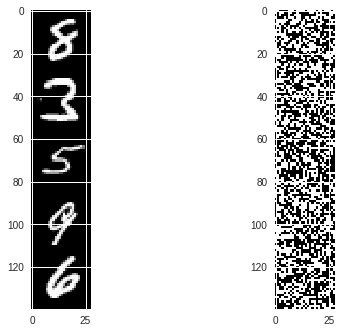

Iteration 1000:


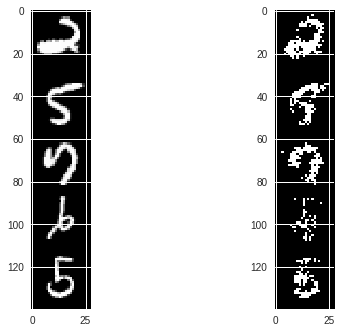

Iteration 2000:


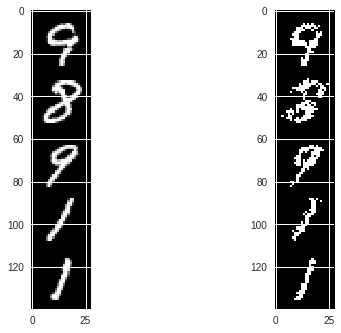

Iteration 3000:


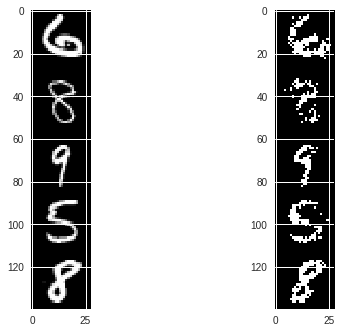

Iteration 4000:


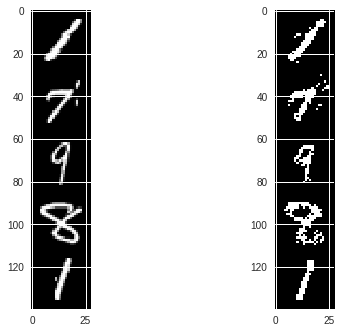

Iteration 5000:


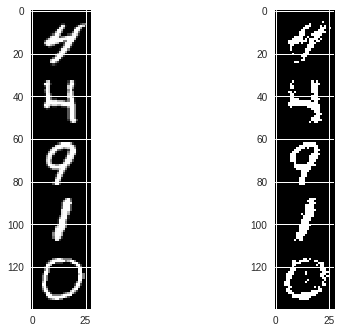

Iteration 6000:


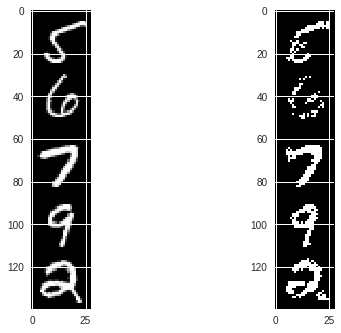

Iteration 7000:


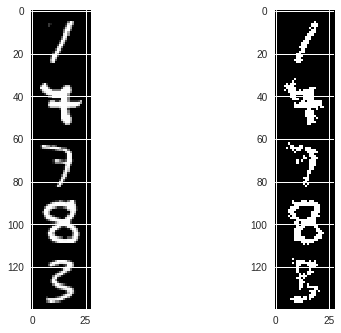

Iteration 8000:


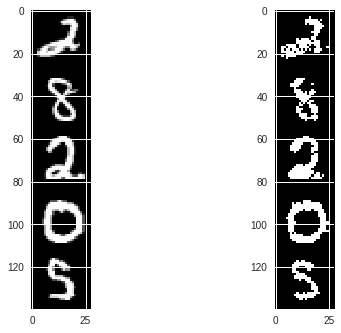

Iteration 9000:


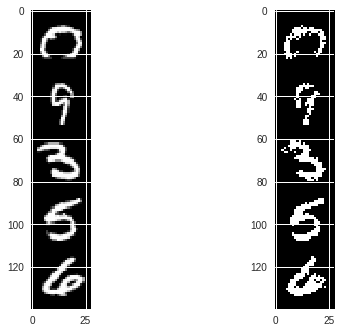

Iteration 10000:


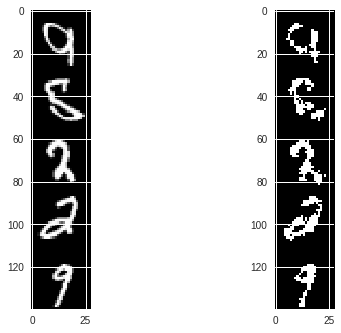

Iteration 11000:


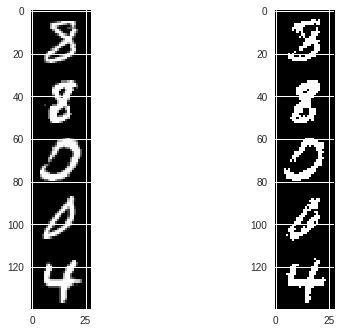

Iteration 12000:


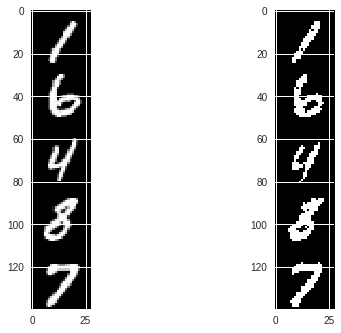

Iteration 13000:


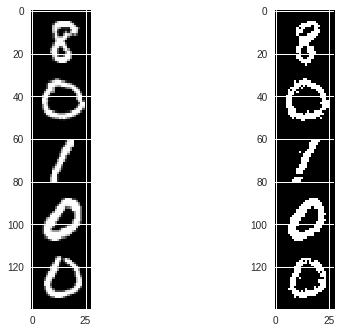

Iteration 14000:


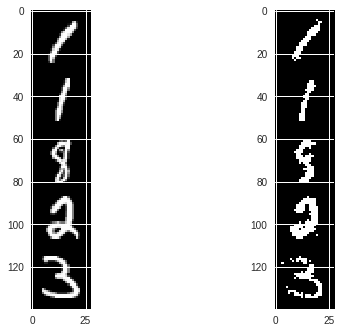

Iteration 15000:


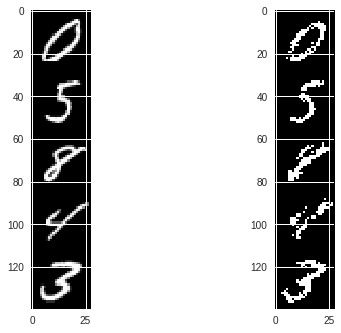

Iteration 16000:


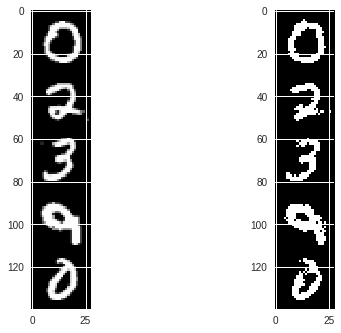

Iteration 17000:


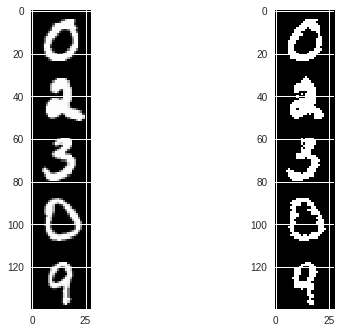

Iteration 18000:


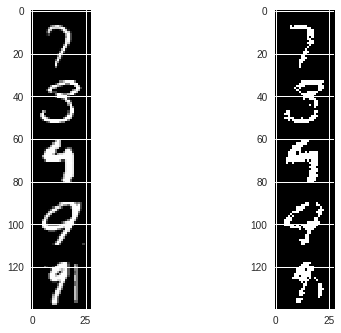

Iteration 19000:


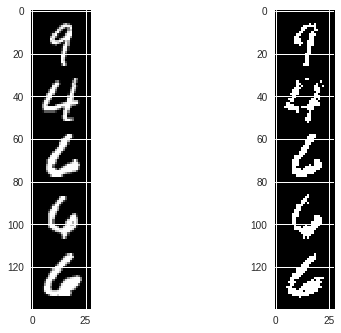

In [0]:
sess = tf.Session()
# Initialize all variables
sess.run(tf.global_variables_initializer())

# Train VAE model
for i in range(20000):        
    # Get a training minibatch
    batch = mnist.train.next_batch(100)

    # Binarize the data
    x_binarized = (batch[0] > 0.5).astype(np.float32)

    # Train on minibatch
    sess.run(train_step_unlabeled, feed_dict={x: x_binarized}) # No labels

    # Visualize reconstructions every 1000 iterations
    if i % 1000 == 0:
        batch = mnist.validation.next_batch(5)
        x_binarized = (batch[0] > 0.5).astype(np.float32)
        reconstructions = sess.run(x_hat, feed_dict={x: x_binarized})
        print("Iteration {0}:".format(i))
        visualize_row_vae(batch[0], reconstructions)